# Minplus algebra experiment

This code attempts to learn the 32D mixture prior
$J(x) = min(\frac{1}{2t\sigma_{1}}||x-\mu_{1}||^{2}, \frac{1}{2\sigma_{2}}||x-\mu_{2}||^{2})$
assuming we have access to training data $\{y_i, S(y_i)\} = min_{x \in \R} \ \{0.5||x-y_i||^{2}_{2} + J(x)\}\}$.

## Import modules 

In [1]:
import os
import numpy as np
import torch

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns

from network import LPN
from lib.utils import cvx
from lib.invert import invert

# set location
MODEL_DIR = "experiments/models/minplus_32D"
os.makedirs(MODEL_DIR, exist_ok=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set random seeds
np.random.seed(1)
torch.manual_seed(1)

# plotting options
plt.rcParams.update({"text.usetex": False})
sns.set_theme()

# Utility functions and plotting tools

In [2]:
##############################
#----- Utlity functions -----#
##############################

# Elementary functions, with the axis specified.
def euclid_norm(x):
    return np.linalg.norm(x, ord = 2, axis = 1)


def inner_prod(x,y):
    return np.sum(x*y, axis = 1)

def euclid_norm_sq(x):
    if x.ndim == 1:
        return np.sum(x*x)
    return np.sum(x * x, axis=1)


def exp_func(x, gamma):
    ''' Proximal matching loss -- x |-> 1 - exp(-(||x||_{2}^{2}/gamma)^{2})
        for training learned proximal networks.
    '''
    return -torch.exp(-((torch.linalg.vector_norm(x, ord = 2, dim = 1)/ gamma) ** 2)) + 1.0


def hjsol_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the solution S(y,t) of the Hamilton--Jacobi
    PDE for the minplus algebra example at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        hjsol:  An n-dimensional numpy array of numbers
    '''

    val1 = 0.5*pow(euclid_norm(y-mu1),2)/(1+sigma1)
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/(1+sigma2)
    hjsol = np.minimum(val1,val2)
    return hjsol


def prior_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes the initial data of the Hamilton--Jacobi
    PDE for the minplus algebra example.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        prior:  An n-dimensional numpy array of numbers
    '''
        
    val1 = 0.5*pow(euclid_norm(y-mu1),2)/sigma1
    val2 = 0.5*pow(euclid_norm(y-mu2),2)/sigma2
    prior = np.minimum(val1,val2)
    return prior


def cvx_true(y,mu1,mu2,sigma1,sigma2):
    '''This function computes 0.5*norm(y)_{2}^{2} - S(y,t) at t = 1.

    Args:
        y:      An n-dimensional numpy array of numbers
        mu1:    An n-dimensional numpy array of numbers
        mu2:    An n-dimensional numpy array of numbers
        sigma1: A positive number
        sigma2: A positive number
    Returns:
        cvx:  An n-dimensional numpy array of numbers
    '''

    cvx = 0.5*pow(euclid_norm(y),2) - hjsol_true(y,mu1,mu2,sigma1,sigma2)
    return cvx


def invert_prior(x, model, INVERT_MODE):
    ''' This function inverts the learned prior at a set of query points x.
    That is, we compute the points y for which nabla_{y}psi(y) = x, 
    where nabla_{y}*psi denotes the gradient of the LPN network.

        Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

        Returns:    y:      The (approximate) set of points for which nabla_{y}psi(y) = x,
                            as a numpy array.
    '''

    y = invert(x,model,INVERT_MODE)
    return y


def evaluate_learned_prior(x, y, model, INVERT_MODE):
    ''' This function evaluates the learned prior at the points y obtained from
    inverting the prior, that is, for which nabla_{y}psi(y) = x, where nabla_{y}psi denotes
    the gradient of the LPN network.
    
    Args:
            x:              A numpy array of real numbers at which to invert the prior.
            model:          The trained LPN model object.
            INVERT_MODE:    The method for inverting the LPN network.

    Returns:    prior_est   The learned initial data (prior) of the HJ PDE at the points x.
    '''

    psi = model.scalar(torch.tensor(y).float().to(device)).squeeze(1).detach().cpu().numpy()
    prior_est = np.sum(x*y, axis = 1) - 0.5 * euclid_norm(x) - psi

    return prior_est

############################
#----- Plotting tools -----#
############################

def compute_square_cross_sections(a, spacing, dim):
    ''' Compute the cross sections (xi,0,...,0) and (0,xi,0,...,0) 
    on the grid [-a,a]^{dim} along the first and second dimensions.

    Args:       a:      A positive number
                spacing: Number of grid spacing along [-a,a]
                dim:    Dimension of the Hamilton--Jacobi PDE

    Returns:    xi:             The numpy array np.linspace(-a, a, spacing)

                x1_0_points:    k x dim numpy array of points, where
                                x_1_0_points[:,0] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size

                x2_0_points:    k x dim numpy array of points, where
                                x_2_0_points[:,1] = np.linspace(-a, a, spacing)
                                with the rest of the entries equal to 0, and
                                k = xi.size
    '''

    xi = np.linspace(-a,a,spacing)
    grid = np.zeros((xi.size, dim))
    x1_0_points = np.copy(grid); x1_0_points[:,0] = xi
    x2_0_points = np.copy(grid); x2_0_points[:,1] = xi

    return xi, x1_0_points, x2_0_points


def cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):
    ''' Compare the true solution of the Hamilton--Jacobi PDE vs the LPN model
        on a square grid [-a,a]^{dim} by overlaying their cross sections along the first and second axes.

    Args:
            model:          The trained LPN model object.
            a:              Measure of the grid [-a,a]^{dim}
            spacing:        Number of points in the interval [-a,a]
            mu1, mu2:       n-dimensional numpy arrays for specifying the initial data
            sigma1, sigma2: Positive numbers for specifying the initial data
            INVERT_MODE:    The method for inverting the LPN network.
            dim:            Spatial dimension of the problem
    '''

    # Compute the cross sections in the first and second axes of the grid [-a,a]^{dim}. 
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)

    # Compute the true initial data and convex functions at the cross section points
    x1_0_cvx_true = cvx_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_cvx_true = cvx_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    x1_0_prior_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    x2_0_prior_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)

    # Compute the learned initial data and convex functions at the cross section points
    x1_0_cvx_est = cvx(x1_0_points,model)
    x2_0_cvx_est = cvx(x2_0_points,model)
    
    y1 = invert(x1_0_points,model,INVERT_MODE)
    y2 = invert(x2_0_points,model,INVERT_MODE)
    x1_0_prior_est = evaluate_learned_prior(x1_0_points, y1, model, INVERT_MODE)
    x2_0_prior_est = evaluate_learned_prior(x2_0_points, y2, model, INVERT_MODE)

    # Plot cross sections of the convex function
    plt.subplots()
    plt.plot(xi, x1_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x1_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the convex function")
    plt.xlabel('$x_1$')
    plt.ylabel('Convex functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_cvx_est, "-", ms=5,label="LPN")
    plt.plot(xi, x2_0_cvx_true, "-", ms=5,label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the convex function")
    plt.xlabel('$x_2$')
    plt.ylabel('Convex functions (0, $x_2$)')
    plt.legend()

    # Plot cross sections of the prior function
    plt.subplots()
    plt.plot(xi, x1_0_prior_est, "-", label="LPN")
    plt.plot(xi, x1_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections ($x_1$,0) of the prior function")
    plt.xlabel('$x_1$')
    plt.ylabel('Prior functions ($x_1$,0)')
    plt.legend()

    plt.subplots()
    plt.plot(xi, x2_0_prior_est, "-", label="LPN")
    plt.plot(xi, x2_0_prior_true, "-", label="Ref")
    plt.grid("on")
    plt.title("Cross sections (0,$x_2$) of the prior function")
    plt.xlabel('$x_2$')
    plt.ylabel('Prior functions (0, $x_2$)')
    plt.legend()




def plot_all(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim):

    # Plot cross sections of the HJ PDEs vs learned proximal network along the first and second dimensions.
    cross_sections_plots(model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

## Parameters

In [3]:
# Dimension
dim = 32

# Prior parameters
mu1 = np.zeros(dim); mu1[0] = 1.0;  sigma1 = 1.0
mu2 = np.ones(dim)/np.sqrt(dim);    sigma2 = 1.0

# Define the spatial grid [-a,a]^{dim}
a, spacing = 4, 100

# Number of samples from the solution we have access to
data_points = 40000
Iterations = 500000

# LPN model parameters
# Note: The defaults parameters are beta = 10, hidden = 50, layers = 4
beta = 2       # beta of softplus
hidden = 200     # number of hidden units
layers = 2      # number of layers

# optimization algorithm to use for computing the prior (cvx_cg, cvx_gd)
INVERT_MODE = "cvx_gd"

## Generate training data

In [4]:
# Generate samples {yi} uniformly in the grid [-a,a]^{dim}
input = np.zeros((dim,data_points))

if(dim>1):
    for k in range(0,dim):
        input[k] = np.random.uniform(-a,a,data_points)
else:
    input = np.random.uniform(-a,a,data_points)

input = input.reshape(data_points,dim)

# Generate the samples
cvx_samples = cvx_true(input,mu1,mu2,sigma1,sigma2).reshape(data_points,-1)

# Recast the samples as tensors
input = torch.from_numpy(input).float()
cvx_samples = torch.from_numpy(cvx_samples).float()

# --- ADD THIS TO MOVE DATA TO GPU ---
input = input.to(device)
cvx_samples = cvx_samples.to(device)

## Training function

In [5]:
def single_iteration(i, data_points, lpn_model, optimizer, input,cvx_samples,loss_type, gamma_loss=None):
    # Compute the convex function from the input.
    cvx_out = lpn_model.scalar(input)

    # Calculate the loss function
    if loss_type == 2:
        loss = (cvx_out - cvx_samples).pow(2).sum() / data_points   # MSE loss
    elif loss_type == 1:
        loss = (cvx_out - cvx_samples).abs().sum() / data_points    # MAE loss
    elif loss_type == 0:
        loss = exp_func(cvx_out - cvx_samples, gamma_loss).mean()   # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 5000:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss -- Train

In [6]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)

for i in range(1):
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-3
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")    
    single_iteration(i, data_points, lpn_model, optimizer,input,cvx_samples,loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

iteration 0 loss 1927.1883544921875
iteration 0 loss 217.9960479736328


iteration 5000 loss 0.3597155809402466


iteration 10000 loss 0.1575828194618225


iteration 15000 loss 0.10667314380407333


iteration 20000 loss 0.0741526260972023


iteration 25000 loss 0.06024748459458351


iteration 30000 loss 0.0493050143122673


iteration 35000 loss 0.05148398131132126


iteration 40000 loss 0.03898118808865547


iteration 45000 loss 0.033534251153469086


iteration 50000 loss 0.031169582158327103


iteration 55000 loss 0.03457037732005119


iteration 60000 loss 0.028788207098841667


iteration 65000 loss 0.024411341175436974


iteration 70000 loss 0.02246631123125553


iteration 75000 loss 0.02105437032878399


iteration 80000 loss 0.01975204609334469


iteration 85000 loss 0.020550742745399475


iteration 90000 loss 0.01801370456814766


iteration 95000 loss 0.0180549044162035


Learning rate decreased to 0.0001 at iteration 100000
iteration 100000 loss 0.018050121143460274


iteration 105000 loss 0.015514584258198738


iteration 110000 loss 0.014459753409028053


iteration 115000 loss 0.013509014621376991


iteration 120000 loss 0.012699772603809834


iteration 125000 loss 0.011954773217439651


iteration 130000 loss 0.011247549206018448


iteration 135000 loss 0.01061085145920515


iteration 140000 loss 0.010020696558058262


iteration 145000 loss 0.009469783864915371


iteration 150000 loss 0.00897704716771841


iteration 155000 loss 0.008545906282961369


iteration 160000 loss 0.008171036839485168


iteration 165000 loss 0.007818527519702911


iteration 170000 loss 0.009804774075746536


iteration 175000 loss 0.0072205993346869946


iteration 180000 loss 0.006965906359255314


iteration 185000 loss 0.006724940147250891


iteration 190000 loss 0.006524689495563507


iteration 195000 loss 0.006320638582110405


Learning rate decreased to 1e-05 at iteration 200000
iteration 200000 loss 0.006146963220089674


iteration 205000 loss 0.00608661537989974


iteration 210000 loss 0.005916129797697067


iteration 215000 loss 0.0057566603645682335


iteration 220000 loss 0.005627764388918877


iteration 225000 loss 0.005486933048814535


iteration 230000 loss 0.005351689178496599


iteration 235000 loss 0.005235017277300358


iteration 240000 loss 0.005123532842844725


iteration 245000 loss 0.0050118775106966496


iteration 250000 loss 0.004900563973933458


iteration 255000 loss 0.0048095108941197395


iteration 260000 loss 0.004717462230473757


iteration 265000 loss 0.004622991196811199


iteration 270000 loss 0.004536180756986141


iteration 275000 loss 0.004460192751139402


iteration 280000 loss 0.004380264785140753


iteration 285000 loss 0.0043029868975281715


iteration 290000 loss 0.004239034838974476


iteration 295000 loss 0.004165216814726591


Learning rate decreased to 1.0000000000000002e-06 at iteration 300000
iteration 300000 loss 0.004098666366189718


iteration 305000 loss 0.004054848570376635


iteration 310000 loss 0.00397501653060317


iteration 315000 loss 0.0038987486623227596


iteration 320000 loss 0.0038237273693084717


iteration 325000 loss 0.0037532278802245855


iteration 330000 loss 0.0036856704391539097


iteration 335000 loss 0.003623331431299448


iteration 340000 loss 0.0035639747511595488


iteration 345000 loss 0.003505307948216796


iteration 350000 loss 0.0034486555960029364


iteration 355000 loss 0.0033964728936553


iteration 360000 loss 0.003343889256939292


iteration 365000 loss 0.0032955650240182877


iteration 370000 loss 0.003248002612963319


iteration 375000 loss 0.003202912164852023


iteration 380000 loss 0.0031583444215357304


iteration 385000 loss 0.003114966442808509


iteration 390000 loss 0.003072556806728244


iteration 395000 loss 0.003033631481230259


Learning rate decreased to 1.0000000000000002e-07 at iteration 400000
iteration 400000 loss 0.0029972963966429234


iteration 405000 loss 0.002989883767440915


iteration 410000 loss 0.002965149935334921


iteration 415000 loss 0.002939216559752822


iteration 420000 loss 0.0029140564147382975


iteration 425000 loss 0.0028895132709294558


iteration 430000 loss 0.0028655051719397306


iteration 435000 loss 0.0028419902082532644


iteration 440000 loss 0.0028189136646687984


iteration 445000 loss 0.002796253189444542


iteration 450000 loss 0.002773975022137165


iteration 455000 loss 0.002752049593254924


iteration 460000 loss 0.002730471780523658


iteration 465000 loss 0.0027092243544757366


iteration 470000 loss 0.0026883170939981937


iteration 475000 loss 0.0026677309069782495


iteration 480000 loss 0.002647432964295149


iteration 485000 loss 0.002627408131957054


iteration 490000 loss 0.0026076557114720345


iteration 495000 loss 0.002588174305856228


L2 loss -- Plot

loss 163.70608520507812


loss 52.59712219238281


loss -26.788658142089844


loss -94.73263549804688


loss -153.02880859375


loss -202.90121459960938


loss -245.25723266601562


loss -280.85064697265625


loss -310.3749694824219


loss -334.50115966796875


loss -353.8834533691406


loss -369.1531982421875


loss -380.91156005859375


loss -389.723388671875


loss -396.1144714355469


loss -400.56878662109375


loss -403.525146484375


loss -405.37249755859375


loss -406.4434509277344


loss -407.0089111328125


loss -407.2740173339844


loss -407.38067626953125


loss -407.4157409667969


loss -407.42449951171875


loss -407.4259948730469


loss -407.4261779785156


loss -407.4261779785156


loss -407.42620849609375


loss -407.4261474609375


loss -407.42620849609375


loss -407.4261779785156


loss -407.4261474609375


loss -407.4261474609375


loss -407.4261474609375


loss -407.4261474609375


loss -407.4261474609375


loss -407.4261474609375


loss -407.4261474609375


loss -407.4261779785156


loss -407.4261474609375


final mse:  3.0721900023955584e-10
max, min: 7.1050644 -8.207997
loss 163.70608520507812


loss 47.126686096191406


loss -35.802223205566406


loss -108.45970916748047


loss -172.120849609375


loss -227.63690185546875


loss -275.72515869140625


loss -317.0338134765625


loss -352.17169189453125


loss -381.72027587890625


loss -406.2381286621094


loss -426.26348876953125


loss -442.3170166015625


loss -454.9038391113281


loss -464.5140380859375


loss -471.62115478515625


loss -476.6776123046875


loss -480.1085205078125


loss -482.3033752441406


loss -483.6072692871094


loss -484.31201171875


loss -484.649169921875


loss -484.78680419921875


loss -484.8324279785156


loss -484.84405517578125


loss -484.8460998535156


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


loss -484.8463134765625


final mse:  2.954803624000135e-10
max, min: 8.15197 -8.773727


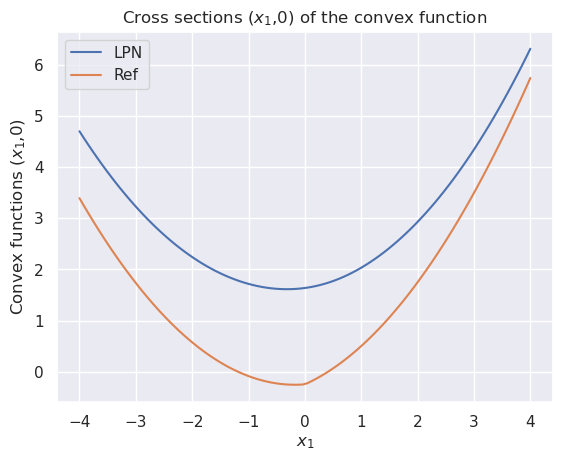

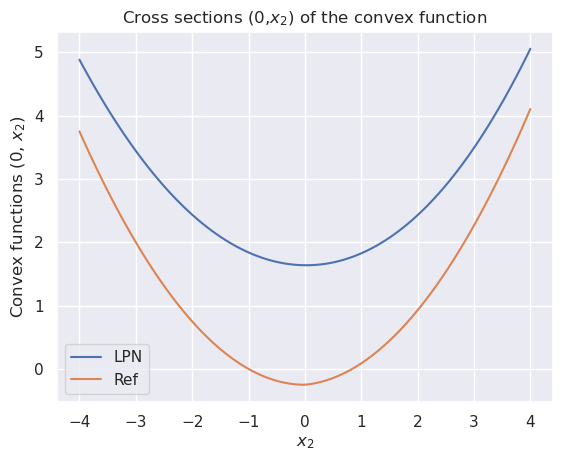

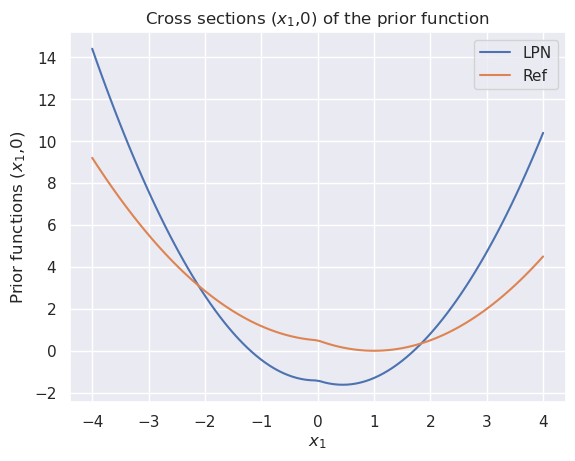

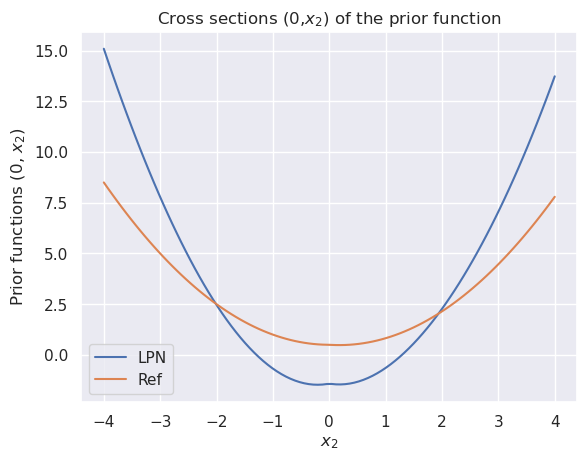

In [7]:
plot_all(lpn_model,a,spacing,mu1,mu2,sigma1,sigma2,INVERT_MODE,dim)

In [8]:
# --- Generate New Training Data for the Second LPN G(x) ---
# We use the same x_j_exp_tensor as the first LPN's training data for x_k
x_k_tensor = input.clone().to(device)
x_k_tensor.requires_grad_(True)

# 1. Compute the gradient y_k = grad_x psi_theta(x_k, t=1)
# Get psi(x_k)
psi_x_k = lpn_model.scalar(x_k_tensor)

# Get gradient y_k = grad_psi(x_k)
y_k_tensor = lpn_model(x_k_tensor)

# 2. Evaluate the "new" samples G_k = <y_k, x_k> - psi_theta(x_k, 1) (from eq 26)
inner_prod_yk_xk = torch.sum(y_k_tensor * x_k_tensor, dim=1, keepdim=True)
G_samples_tensor_with_graph = inner_prod_yk_xk - psi_x_k

# Detach the tensor to treat G_k as fixed targets, breaking the connection
# to the first LPN's graph and preventing the RuntimeError during training.
G_samples_tensor = G_samples_tensor_with_graph.detach().to(device) 

# The input tensor x_k_tensor is still needed for the second LPN training,
# but it should also not require a gradient for that training.
x_k_tensor = x_k_tensor.detach()
x_k_tensor.requires_grad_(False) 
y_k_tensor = y_k_tensor.detach()
y_k_tensor.requires_grad_(False)
# G_samples_tensor now holds the target values G_k
print(f"Generated G samples: G_samples_tensor shape {G_samples_tensor.shape}")

# --- Step 3: Train LPN G(x) ---
print("\n--- Training Second LPN G(x) for Concave Quadratic Prior ---")
# The target for this LPN is G_samples_tensor
# The input for this LPN is x_k_tensor
lpn_model_G = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta, eps=1e-3).to(device)
optimizer_G = torch.optim.Adam(lpn_model_G.parameters(), lr=1e-4)

# Initial shorter training phase
for i in range(1):
     single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

for g in optimizer_G.param_groups:
    g["lr"] = 1e-4 
for i in range(Iterations):
    if (i % 100000 == 0) and (i > 0): 
        # Multiply the current learning rate by 1e-1
        for g in optimizer_G.param_groups:
            new_lr = g["lr"] * 1e-1
            g["lr"] = new_lr
        print(f"Learning rate decreased to {new_lr} at iteration {i}")
    single_iteration(i, data_points, lpn_model_G, optimizer_G, y_k_tensor, G_samples_tensor, loss_type=2, gamma_loss=None)

torch.save(lpn_model_G.state_dict(), os.path.join(MODEL_DIR, "G_network_l2.pth"))
print("Training of LPN for G(x) complete and model saved.")

Generated G samples: G_samples_tensor shape torch.Size([40000, 1])

--- Training Second LPN G(x) for Concave Quadratic Prior ---
iteration 0 loss 1738.1751708984375
iteration 0 loss 446.8216857910156


iteration 5000 loss 11.190326690673828


iteration 10000 loss 1.2831178903579712


iteration 15000 loss 0.4734857380390167


iteration 20000 loss 0.27451983094215393


iteration 25000 loss 0.21186889708042145


iteration 30000 loss 0.1730564385652542


iteration 35000 loss 0.1490333080291748


iteration 40000 loss 0.13379670679569244


iteration 45000 loss 0.12029507756233215


iteration 50000 loss 0.11015722155570984


iteration 55000 loss 0.7100453972816467


iteration 60000 loss 0.09649500995874405


iteration 65000 loss 0.0903787910938263


iteration 70000 loss 0.08570286631584167


iteration 75000 loss 0.08074154704809189


iteration 80000 loss 0.07646625488996506


iteration 85000 loss 0.072404645383358


iteration 90000 loss 0.06845800578594208


iteration 95000 loss 0.06574874371290207


Learning rate decreased to 1e-05 at iteration 100000
iteration 100000 loss 0.06267063319683075


iteration 105000 loss 0.06072108447551727


iteration 110000 loss 0.058235980570316315


iteration 115000 loss 0.05582442507147789


iteration 120000 loss 0.053490012884140015


iteration 125000 loss 0.05157249793410301


iteration 130000 loss 0.04952358826994896


iteration 135000 loss 0.047814708203077316


iteration 140000 loss 0.04607563093304634


iteration 145000 loss 0.04447900131344795


iteration 150000 loss 0.04298308491706848


iteration 155000 loss 0.0415545217692852


iteration 160000 loss 0.04022315517067909


iteration 165000 loss 0.03885442763566971


iteration 170000 loss 0.03770804777741432


iteration 175000 loss 0.03643079474568367


iteration 180000 loss 0.03546788915991783


iteration 185000 loss 0.03448037430644035


iteration 190000 loss 0.03342112526297569


iteration 195000 loss 0.032504577189683914


Learning rate decreased to 1.0000000000000002e-06 at iteration 200000
iteration 200000 loss 0.03166025131940842


iteration 205000 loss 0.031487878412008286


iteration 210000 loss 0.030709417536854744


iteration 215000 loss 0.02989812009036541


iteration 220000 loss 0.029159240424633026


iteration 225000 loss 0.02845892310142517


iteration 230000 loss 0.027819937095046043


iteration 235000 loss 0.027198681607842445


iteration 240000 loss 0.026614293456077576


iteration 245000 loss 0.026052197441458702


iteration 250000 loss 0.025517329573631287


iteration 255000 loss 0.025014324113726616


iteration 260000 loss 0.024530062451958656


iteration 265000 loss 0.024064676836133003


iteration 270000 loss 0.023623516783118248


iteration 275000 loss 0.023203693330287933


iteration 280000 loss 0.022793160751461983


iteration 285000 loss 0.022405236959457397


iteration 290000 loss 0.022036638110876083


iteration 295000 loss 0.021680030971765518


Learning rate decreased to 1.0000000000000002e-07 at iteration 300000
iteration 300000 loss 0.021339241415262222


iteration 305000 loss 0.021277235820889473


iteration 310000 loss 0.02120046690106392


iteration 315000 loss 0.021127719432115555


iteration 320000 loss 0.021057529374957085


iteration 325000 loss 0.02098916843533516


iteration 330000 loss 0.02092231996357441


iteration 335000 loss 0.020856725051999092


iteration 340000 loss 0.020792260766029358


iteration 345000 loss 0.02072872780263424


iteration 350000 loss 0.020666060969233513


iteration 355000 loss 0.020604247227311134


iteration 360000 loss 0.020543251186609268


iteration 365000 loss 0.02048296108841896


iteration 370000 loss 0.02042342722415924


iteration 375000 loss 0.02036447450518608


iteration 380000 loss 0.02030617743730545


iteration 385000 loss 0.02024846151471138


iteration 390000 loss 0.02019130438566208


iteration 395000 loss 0.02013467438519001


Learning rate decreased to 1.0000000000000004e-08 at iteration 400000
iteration 400000 loss 0.020078521221876144


iteration 405000 loss 0.02007397450506687


iteration 410000 loss 0.02006937563419342


iteration 415000 loss 0.02006484568119049


iteration 420000 loss 0.020060362294316292


iteration 425000 loss 0.02005591057240963


iteration 430000 loss 0.0200515016913414


iteration 435000 loss 0.02004712074995041


iteration 440000 loss 0.020042764022946358


iteration 445000 loss 0.020038435235619545


iteration 450000 loss 0.020034126937389374


iteration 455000 loss 0.02002984844148159


iteration 460000 loss 0.02002558298408985


iteration 465000 loss 0.020021339878439903


iteration 470000 loss 0.020017117261886597


iteration 475000 loss 0.02001291513442993


iteration 480000 loss 0.020008714869618416


iteration 485000 loss 0.020004551857709885


iteration 490000 loss 0.020000392571091652


iteration 495000 loss 0.01999625377357006


Training of LPN for G(x) complete and model saved.



--- Plotting Estimated Prior J(x) from 2nd LPN---


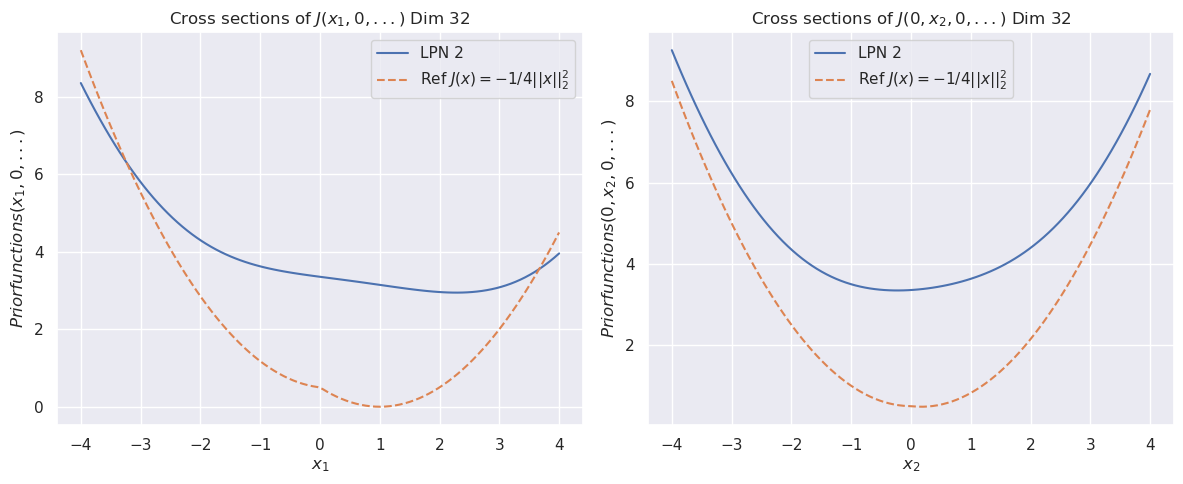

In [9]:
def evaluate_learned_J_G_network(x_points, model_G):
    """
    Evaluates the learned prior J(x) using the trained G(x) network.
    J(x) = G(x) - 0.5 * ||x||^2
    """
    # Convert to tensor
    x_tensor = torch.from_numpy(x_points).float().to(device)
    
    # Get G(x) from the second LPN model
    G_x = model_G.scalar(x_tensor)
    
    # Compute 0.5 * ||x||^2
    x_norm_sq_np = euclid_norm_sq(x_points)
    x_norm_sq_tensor = torch.from_numpy(x_norm_sq_np).float().to(device).reshape(-1, 1)

    # Apply the formula: J_est = G(x) - 0.5 * ||x||^2
    J_est = G_x - 0.5 * x_norm_sq_tensor
    
    # Convert back to numpy
    J_est_np = J_est.detach().cpu().numpy().flatten()
    
    return J_est_np

def plot_J_G_network(model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2):
    """Plots the cross-sections of the estimated prior J(x) from the G network."""
    xi, x1_0_points, x2_0_points = compute_square_cross_sections(a, spacing, dim)
    # True Prior
    x1_0_J_true = prior_true(x1_0_points,mu1,mu2,sigma1,sigma2)
    if dim > 1:
        x2_0_J_true = prior_true(x2_0_points,mu1,mu2,sigma1,sigma2)
    else:
        x2_0_J_true = x1_0_J_true
        
    # Estimated Prior from G(x) Network
    x1_0_J_G_est = evaluate_learned_J_G_network(x1_0_points, model_G)
    if dim > 1:
        x2_0_J_G_est = evaluate_learned_J_G_network(x2_0_points, model_G)
    else:
        x2_0_J_G_est = x1_0_J_G_est
    
    print("\n--- Plotting Estimated Prior J(x) from 2nd LPN---")
    plt.figure(figsize=(12,5))
    
    plt.subplot(1, 2, 1)
    plt.plot(xi, x1_0_J_G_est, "-", label="LPN 2")
    plt.plot(xi, x1_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
    plt.grid(True)
    plt.title(f"Cross sections of $J(x_1,0,...)$ Dim {dim}")
    plt.xlabel('$x_1$')
    plt.ylabel('$Prior functions (x_1,0,...)$')
    plt.legend()

    if dim > 1:
        plt.subplot(1, 2, 2)
        plt.plot(xi, x2_0_J_G_est, "-", label="LPN 2")
        plt.plot(xi, x2_0_J_true, "--", label="Ref $J(x)=-1/4||x||_2^2$")
        plt.grid(True)
        plt.title(f"Cross sections of $J(0,x_2,0,...)$ Dim {dim}")
        plt.xlabel('$x_2$')
        plt.ylabel('$Prior functions (0,x_2,0,...)$')
        plt.legend()
    plt.tight_layout()
    #plt.savefig('G_network_prior_plot.png')
    
# --- Execute Plotting ---
plot_J_G_network(lpn_model_G, a, spacing, dim,mu1,mu2,sigma1,sigma2)